## Analysis for glutamate imaging

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from utils_swim import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
from pathlib import Path
vol_file = '../Voltron_data/SnFR_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/GlutData/'
dir_folder = Path(dat_folder)

## Random Gain

### Motor clamp

In [3]:
frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16
color_list = ['k', 'r', 'b']

In [4]:
vel_list = []
power_list = []
fish_list = []

In [6]:
for index, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Random Gain':
        continue
    if row['area'] != 'Glu':
        continue
    folder = row['folder']
    fish = row['fish']
    rootDir = row['rootDir']
#     swim(folder, fish, rootDir, dat_folder)
#     trial_swim_power(folder, fish, dir_folder)
#     frame_swim_power(folder, fish, dir_folder)
#     frame_swim_power_series(folder, fish, dir_folder)
    
    swm_dir = dat_folder+f'{folder}/{fish}/swim/'
    img_dir = rootDir+f'{folder}/{fish}/Registered'

    # get valid swim data
    frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
    frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
    rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
    swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
    reclen=len(swimdata['fltCh1'])
    frame_tcourse=np.zeros((reclen,))
    frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
    for t in range(len(frame)-1):
        frame_tcourse[frame[t]:frame[t+1]]=t
    swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
    swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
    # collect trial within t-pre, and t-post valid range
    swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    valid = np.diff(swim_start) > t_post
    swim_end = swim_end[:-1][valid]
    swim_start = swim_start[:-1][valid]
    
    dFF = np.load(img_dir+'/dFF_sub.npy')[()]
    dim = dFF.shape
    dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels
    ave = np.load(img_dir+'/stack_sub.npy')[()]
    ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
    include_pix=np.where(ave>150)[1]
    dFF = dFF[:, include_pix]
    n_pix = dFF.shape[-1]
    
    swim_list = []
    for ntype in range(3):
        _ = swim_start[np.where(frame_stimParams[2,swim_start+2]==ntype+1)[0]]
        valid = np.diff(_) > t_post
        if valid.sum()<10:
            continue
        swim_list.append(_[:-1][valid])
    
    if len(swim_list)<3:
        continue
    if np.concatenate(swim_list).shape[0]<30:
        continue

    dff_list = []
    pswim_list = []
    vis_list = []
    num_swim_list = []
    ppswim_list = []
    pvis_list = []
    t_len = int(t_pre+t_post)
    for nswim in swim_list:
        num_swim = len(nswim)
        num_swim_list.append(num_swim)
        dff_ = np.zeros((num_swim, t_len, n_pix))
        pswim_ = np.zeros((num_swim, t_len))
        pswim_pre = np.zeros((num_swim, t_len))
        pswim_pre[:] = np.nan
        vis_ = np.zeros((num_swim, t_len))
        vis_pre = np.zeros((num_swim, t_len))
        vis_pre[:] = np.nan
        for ns, s in enumerate(nswim):
            l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
            r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
            pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
            vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
            dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
            pre_swim = np.where(swim_start==s)[0][0]-1
            if pre_swim>=0:
                pre_swim = swim_start[pre_swim]
                l_swim = frame_swim_tcourse[1,(pre_swim-t_pre):(pre_swim+t_post)]
                r_swim = frame_swim_tcourse[2,(pre_swim-t_pre):(pre_swim+t_post)]
                pswim_pre[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 
                vis_pre[ns] = -frame_stimParams[0,(pre_swim-t_pre):(pre_swim+t_post)]*10000
        valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
        valid_ = valid_ & (pswim_.max(axis=-1)<20)
        valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
        valid_ = valid_ & (np.isnan(pswim_pre).sum(axis=-1)==0)
        dff_list.append(dff_[valid_])
        pswim_list.append(pswim_[valid_])
        vis_list.append(vis_[valid_])
        ppswim_list.append(pswim_pre[valid_])
        pvis_list.append(vis_pre[valid_])
        
#     fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#     ax = ax.flatten()
#     color_list = ['k', 'r', 'b']
#     for n in range(3):
#         ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
#         ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
#         ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
#     sns.despine()
#     ax[0].set_xlim([-0.2, 1.0])
#     ax[1].set_xlim([-0.2, 1.0])
#     ax[2].set_xlim([-0.2, 1.0])
#     plt.show()
    
    fish_list.append(folder+fish[:5])
    tmp1 = []
    tmp2 = []
    for n in range(3):
        ave_dff = dff_list[n].mean(axis=-1)*100
        v_ = -(vis_list[n][:, :].min(axis=-1))
        d_ = ave_dff[:, t_pre+6:t_pre+10].mean(axis=-1)
        tmp1.append(v_)
        tmp2.append(d_)
    vel_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))
    
    tmp1 = []
    tmp2 = []
    for n in range(3):
        ave_dff = dff_list[n].mean(axis=-1)*100
        v_ = -(vis_list[n][:, :].min(axis=-1))
        p_ = pswim_list[n][:, :].max(axis=-1)
        d_ = ave_dff[:, t_pre-2:t_pre+2].mean(axis=-1)
        tmp1.append(p_)
        # tmp1.append(v_)
        tmp2.append(d_)
#         plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
#     plt.xlabel('Swim power')
#     plt.ylabel('dF/F')
#     # plt.legend()
#     sns.despine()
#     plt.show()
    power_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))

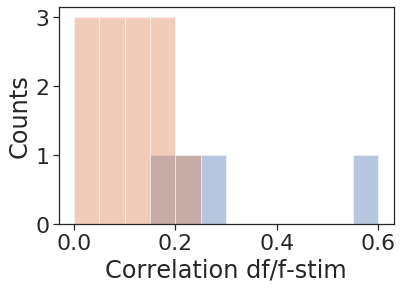

In [7]:
vel_list_ = np.array(vel_list)
sns.distplot(vel_list_[vel_list_[:,1]<0.05, 0], bins=np.arange(0, 0.65, 0.05), kde=False)
sns.distplot(vel_list_[vel_list_[:,1]>0.05, 0], bins=np.arange(0, 0.65, 0.05), kde=False)
plt.ylabel('Counts')
plt.xlabel('Correlation df/f-stim')
plt.show()

power_list_ = np.array(power_list)
sns.distplot(power_list_[power_list_[:,1]<0.05, 0], bins=np.arange(-0.3, 0.65, 0.05), kde=False)
sns.distplot(power_list_[power_list_[:,1]>0.05, 0], bins=np.arange(-0.3, 0.65, 0.05), kde=False)
plt.ylabel('Counts')
plt.xlabel('Correlation df/f-swim power')
plt.show()

### Visual clamp

In [ ]:
vel_list = []
power_list = []
fish_list = []

In [ ]:
for index, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Random Gain':
        continue
    if row['area'] != 'Glu':
        continue
    folder = row['folder']
    fish = row['fish']
    rootDir = row['rootDir']
    
    swm_dir = dat_folder+f'{folder}/{fish}/swim/'
    img_dir = rootDir+f'{folder}/{fish}/Registered'

    # get valid swim data
    frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
    frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
    rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
    swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
    reclen=len(swimdata['fltCh1'])
    frame_tcourse=np.zeros((reclen,))
    frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
    for t in range(len(frame)-1):
        frame_tcourse[frame[t]:frame[t+1]]=t
    swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
    swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
    # collect trial within t-pre, and t-post valid range
    swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    valid = np.diff(swim_start) > t_post
    swim_end = swim_end[:-1][valid]
    swim_start = swim_start[:-1][valid]
    
    dFF = np.load(img_dir+'/dFF_sub.npy')[()]
    dim = dFF.shape
    dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels
    ave = np.load(img_dir+'/stack_sub.npy')[()]
    ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
    include_pix=np.where(ave>150)[1]
    dFF = dFF[:, include_pix]
    n_pix = dFF.shape[-1]
    
    swim_list = []
    for ntype in range(3):
        _ = swim_start[np.where(frame_stimParams[2,swim_start+2]==ntype+1)[0]]
        valid = np.diff(_) > t_post
        if valid.sum()<10:
            continue
        swim_list.append(_[:-1][valid])
    
    if len(swim_list)<3:
        continue
    if np.concatenate(swim_list).shape[0]<30:
        continue

    dff_list = []
    pswim_list = []
    vis_list = []
    num_swim_list = []
    ppswim_list = []
    pvis_list = []
    t_len = int(t_pre+t_post)
    for nswim in swim_list:
        num_swim = len(nswim)
        num_swim_list.append(num_swim)
        dff_ = np.zeros((num_swim, t_len, n_pix))
        pswim_ = np.zeros((num_swim, t_len))
        pswim_pre = np.zeros((num_swim, t_len))
        pswim_pre[:] = np.nan
        vis_ = np.zeros((num_swim, t_len))
        vis_pre = np.zeros((num_swim, t_len))
        vis_pre[:] = np.nan
        for ns, s in enumerate(nswim):
            l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
            r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
            pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
            vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
            dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
            pre_swim = np.where(swim_start==s)[0][0]-1
            if pre_swim>=0:
                pre_swim = swim_start[pre_swim]
                l_swim = frame_swim_tcourse[1,(pre_swim-t_pre):(pre_swim+t_post)]
                r_swim = frame_swim_tcourse[2,(pre_swim-t_pre):(pre_swim+t_post)]
                pswim_pre[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 
                vis_pre[ns] = -frame_stimParams[0,(pre_swim-t_pre):(pre_swim+t_post)]*10000
        valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
        valid_ = valid_ & (pswim_.max(axis=-1)<20)
        valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
        valid_ = valid_ & (np.isnan(pswim_pre).sum(axis=-1)==0)
        dff_list.append(dff_[valid_])
        pswim_list.append(pswim_[valid_])
        vis_list.append(vis_[valid_])
        ppswim_list.append(pswim_pre[valid_])
        pvis_list.append(vis_pre[valid_])
        
#     fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#     ax = ax.flatten()
#     color_list = ['k', 'r', 'b']
#     for n in range(3):
#         ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
#         ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
#         ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
#     sns.despine()
#     ax[0].set_xlim([-0.2, 1.0])
#     ax[1].set_xlim([-0.2, 1.0])
#     ax[2].set_xlim([-0.2, 1.0])
#     plt.show()
    
    fish_list.append(folder+fish[:5])
    tmp1 = []
    tmp2 = []
    for n in range(3):
        ave_dff = dff_list[n].mean(axis=-1)*100
        v_ = -(vis_list[n][:, :].min(axis=-1))
        d_ = ave_dff[:, t_pre+6:t_pre+10].mean(axis=-1)
        tmp1.append(v_)
        tmp2.append(d_)
    vel_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))
    
    tmp1 = []
    tmp2 = []
    for n in range(3):
        ave_dff = dff_list[n].mean(axis=-1)*100
        v_ = -(vis_list[n][:, :].min(axis=-1))
        p_ = pswim_list[n][:, :].max(axis=-1)
        d_ = ave_dff[:, t_pre-2:t_pre+2].mean(axis=-1)
        tmp1.append(p_)
        # tmp1.append(v_)
        tmp2.append(d_)
#         plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
#     plt.xlabel('Swim power')
#     plt.ylabel('dF/F')
#     # plt.legend()
#     sns.despine()
#     plt.show()
    power_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))

## Gain Adapation

In [9]:
frame_rate = 30
t_pre = 20
t_post = 10 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16
color_list = ['k', 'r', 'b']
vel_list = []
power_list = []
fish_list = []

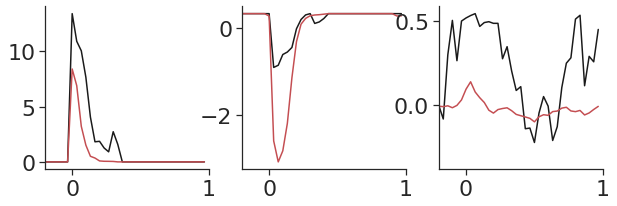

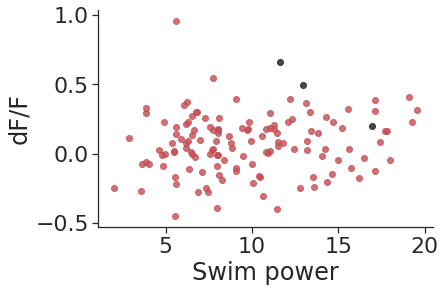

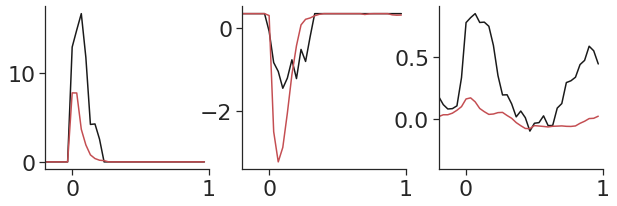

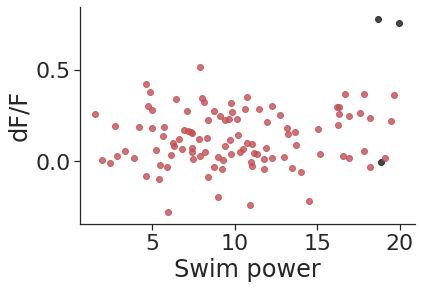

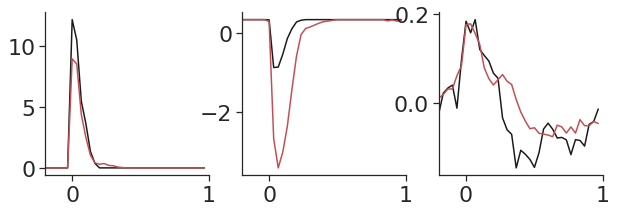

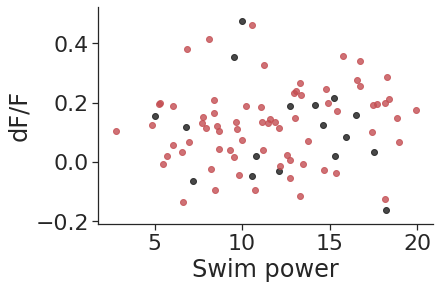

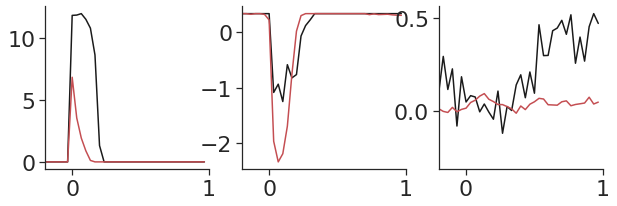

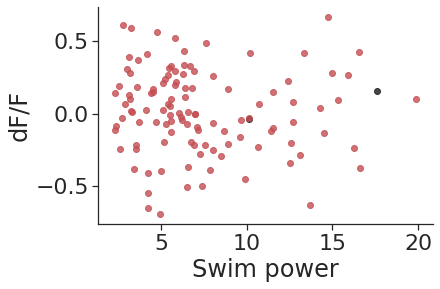

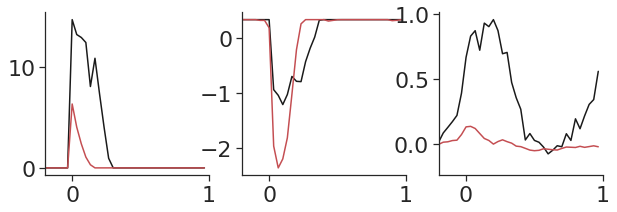

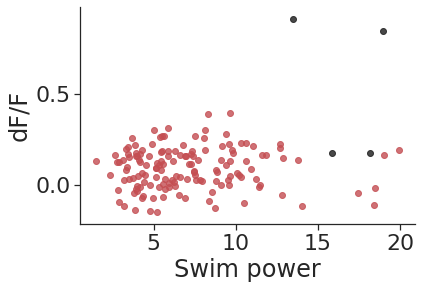

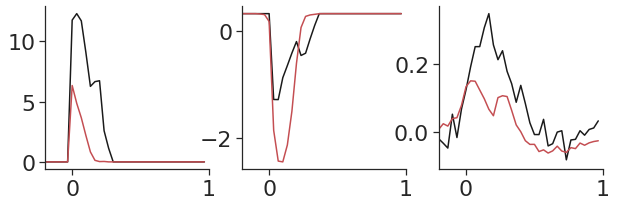

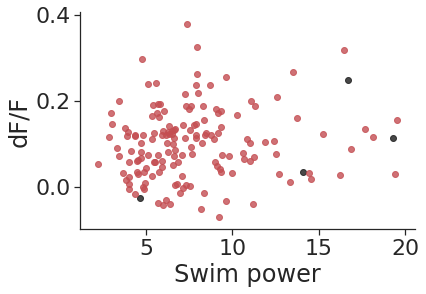

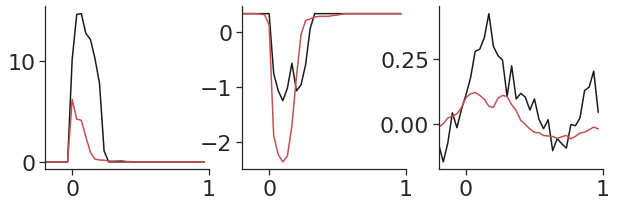

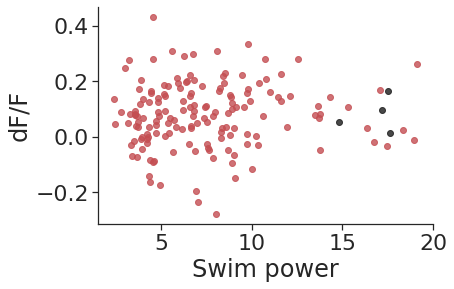

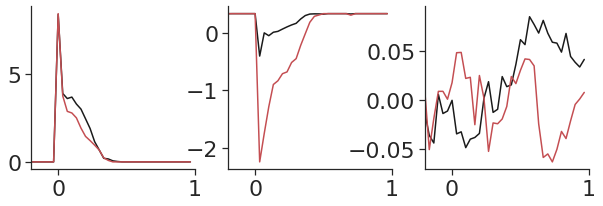

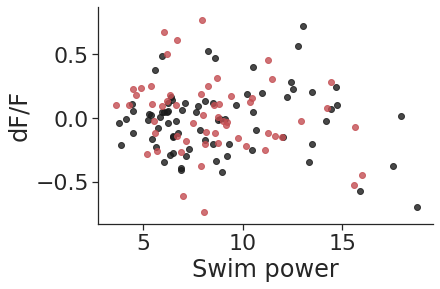

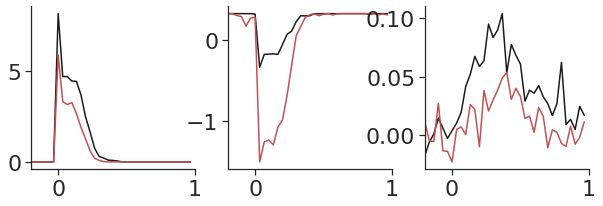

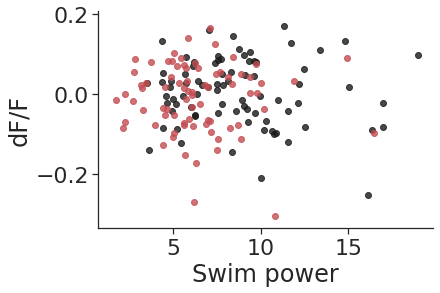

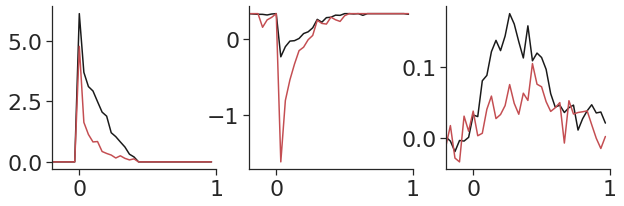

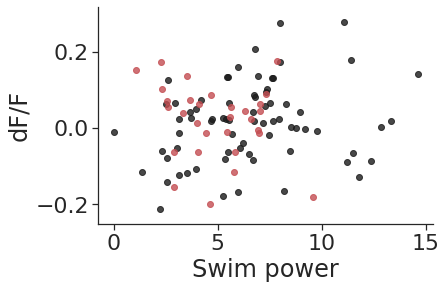

In [5]:
for index, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Gain adaptation':
        continue
    if row['area'] != 'Glu':
        continue
    folder = row['folder']
    fish = row['fish']
    rootDir = row['rootDir']
#     swim(folder, fish, rootDir, dat_folder)
#     trial_swim_power(folder, fish, dir_folder)
#     frame_swim_power(folder, fish, dir_folder)
#     frame_swim_power_series(folder, fish, dir_folder)
    
    swm_dir = dat_folder+f'{folder}/{fish}/swim/'
    img_dir = rootDir+f'{folder}/{fish}/Registered'

    # get valid swim data
    frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
    frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
    rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
    swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
    reclen=len(swimdata['fltCh1'])
    frame_tcourse=np.zeros((reclen,))
    frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
    for t in range(len(frame)-1):
        frame_tcourse[frame[t]:frame[t+1]]=t
    swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
    swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
    # collect trial within t-pre, and t-post valid range
    swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    valid = np.diff(swim_start) > t_post
    swim_end = swim_end[:-1][valid]
    swim_start = swim_start[:-1][valid]
    
    dFF = np.load(img_dir+'/dFF_sub.npy')[()]
    dim = dFF.shape
    dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels
    ave = np.load(img_dir+'/stack_sub.npy')[()]
    ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
    include_pix=np.where(ave>150)[1]
    dFF = dFF[:, include_pix]
    n_pix = dFF.shape[-1]
    
    swim_list = []
    for ntype in range(3):
        _ = swim_start[np.where(frame_stimParams[2,swim_start+2]==ntype+1)[0]]
        valid = np.diff(_) > t_post
        if valid.sum()<10:
            continue
        swim_list.append(_[:-1][valid])
    
    if len(swim_list)<2:
        continue
    if np.concatenate(swim_list).shape[0]<30:
        continue

    dff_list = []
    pswim_list = []
    vis_list = []
    num_swim_list = []
    ppswim_list = []
    pvis_list = []
    t_len = int(t_pre+t_post)
    for nswim in swim_list:
        num_swim = len(nswim)
        num_swim_list.append(num_swim)
        dff_ = np.zeros((num_swim, t_len, n_pix))
        pswim_ = np.zeros((num_swim, t_len))
        pswim_pre = np.zeros((num_swim, t_len))
        pswim_pre[:] = np.nan
        vis_ = np.zeros((num_swim, t_len))
        vis_pre = np.zeros((num_swim, t_len))
        vis_pre[:] = np.nan
        for ns, s in enumerate(nswim):
            l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
            r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
            pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
            vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
            dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
            pre_swim = np.where(swim_start==s)[0][0]-1
            if pre_swim>=0:
                pre_swim = swim_start[pre_swim]
                l_swim = frame_swim_tcourse[1,(pre_swim-t_pre):(pre_swim+t_post)]
                r_swim = frame_swim_tcourse[2,(pre_swim-t_pre):(pre_swim+t_post)]
                pswim_pre[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 
                vis_pre[ns] = -frame_stimParams[0,(pre_swim-t_pre):(pre_swim+t_post)]*10000
        valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
        # valid_ = valid_ & (pswim_.max(axis=-1)<20)
        valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
        valid_ = valid_ & (np.isnan(pswim_pre).sum(axis=-1)==0)
        dff_list.append(dff_[valid_])
        pswim_list.append(pswim_[valid_])
        vis_list.append(vis_[valid_])
        ppswim_list.append(pswim_pre[valid_])
        pvis_list.append(vis_pre[valid_])
        
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax = ax.flatten()
    color_list = ['k', 'r', 'b']
    for n in range(2):
        ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
        ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
        ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    sns.despine()
    ax[0].set_xlim([-0.2, 1.0])
    ax[1].set_xlim([-0.2, 1.0])
    ax[2].set_xlim([-0.2, 1.0])
    plt.show()
    
    fish_list.append(folder+fish[:5])
    tmp1 = []
    tmp2 = []
    for n in range(2):
        ave_dff = dff_list[n].mean(axis=-1)*100
        v_ = -(vis_list[n][:, :].min(axis=-1))
        d_ = ave_dff[:, t_pre+6:t_pre+10].mean(axis=-1)
        tmp1.append(v_)
        tmp2.append(d_)
    vel_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))
    
    tmp1 = []
    tmp2 = []
    for n in range(2):
        ave_dff = dff_list[n].mean(axis=-1)*100
        p_ = pswim_list[n][:, :].max(axis=-1)
        d_ = ave_dff[:, t_pre-2:t_pre+2].mean(axis=-1)
        tmp1.append(p_)
        tmp2.append(d_)
        plt.scatter(p_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    plt.xlabel('Swim power')
    plt.ylabel('dF/F')
    # plt.legend()
    sns.despine()
    plt.show()
    power_list.append(spearmanr(np.concatenate(tmp1), np.concatenate(tmp2)))